In [140]:
import argparse
import logging
import numpy as np
from astropy.io import fits
from astropy import stats
from astropy import time
import matplotlib.pyplot as plt
import astropy.time as astt

import glob

In [141]:
#inputdirectory='/Users/dharbeck/lco/dl-st428/sd06-ptc/*-[bx]00.fits.fz'
inputdirectory='/Users/dharbeck/lco/cosmos/HDR/*-[bx]00.fits.fz'
#inputdirectory='/Users/dharbeck/lco/qhy600/ptcsq42/*-[bx]00.fits.fz'

inputfiles = glob.glob (inputdirectory)
print (len(inputfiles))

133


In [142]:
def get_level_exptime_for_file (fitsfilename, minx=1000,maxx=1050,miny=1000,maxy=1050):
    f = fits.open(fitsfilename)
    data = f['SCI'].data[miny:maxy,minx:maxx]
    if 'x00' in fitsfilename:
        exptime = f['SCI'].header['REQTIME'] 
    else:
        exptime = 0
    dateobs = f['SCI'].header['DATE-OBS']
    dateobst = astt.Time(dateobs, scale='utc', format=None).to_datetime()
    level = np.median (data)
    std = np.std(data)
    level = np.average ( data [ np.abs(data-level) < 3*std])
    f.close()
    del data
    return exptime, level, dateobst

exptimes = []
levels = []
dateobs = []

for file in inputfiles:
    exptime,level,dateobst = get_level_exptime_for_file(file)
    exptimes.append (exptime)
    levels.append (level)
    dateobs.append(dateobst)
exptimes = np.asarray (exptimes)
levels = np.asarray (levels)
dateobs = np.asarray (dateobs)

Bias LEvel fit: 494.40245101520526


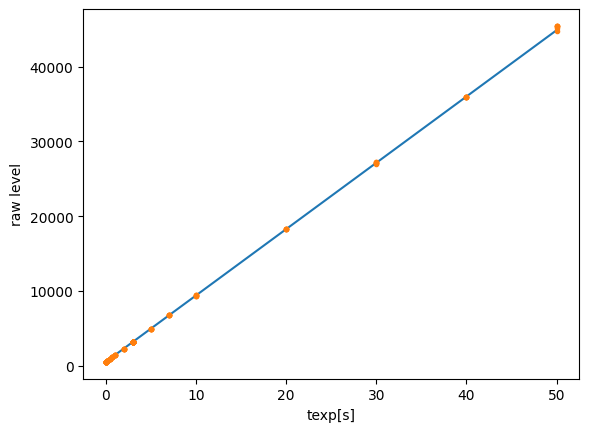

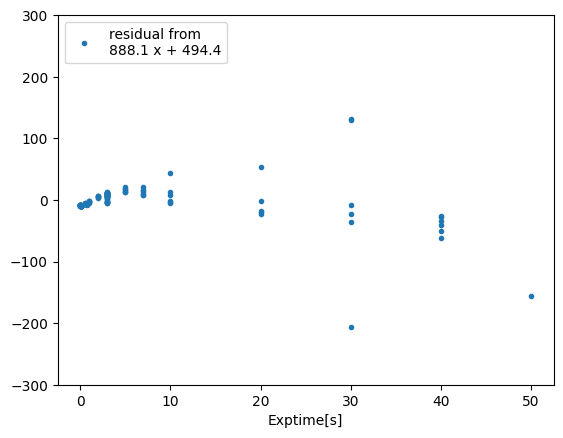

In [144]:
plt.figure()
cond = (exptimes<40)&(exptimes>=0)
fitorder=1
z = np.polyfit(exptimes[cond], levels[cond], fitorder)
p = np.poly1d(z)
residuals = (levels - p (exptimes))
cond = cond & (np.abs (residuals) < 100)
z = np.polyfit(exptimes[cond], levels[cond], fitorder)
p = np.poly1d(z)
residuals = (levels - p (exptimes))

good=np.abs (residuals) <200

plt.xlabel ("texp[s]")
plt.ylabel ("raw level")
x = np.arange(0,np.max(exptimes),0.1)
plt.plot (x,p(x))
plt.plot (exptimes, levels,'.')
fittedbiaslevel = p[0]
print (f"Bias Level fit: {fittedbiaslevel}" )

plt.savefig ("linearfit.png")
plt.figure()
plt.plot (exptimes, residuals, '.', label=f"residual from {p}")
plt.legend()
plt.xlabel("Exptime[s]")
plt.ylim(-300,300)
plt.savefig ("linearfitresidual.png")

Biaslevel: 485.7590522687265


/var/folders/rr/wl6nqmp921x1mqz575fbfnpc0000gn/T/ipykernel_50542/2066580705.py:5: RuntimeWarning: divide by zero encountered in divide
  plt.plot (exptimes, (levels-biaslevel) / exptimes,'.', label=f"Bias from bias image {biaslevel}")
/var/folders/rr/wl6nqmp921x1mqz575fbfnpc0000gn/T/ipykernel_50542/2066580705.py:6: RuntimeWarning: divide by zero encountered in divide
  plt.plot (exptimes, (levels-fittedbiaslevel) / exptimes,'.',label=f"Bias from fit {fittedbiaslevel}")
/var/folders/rr/wl6nqmp921x1mqz575fbfnpc0000gn/T/ipykernel_50542/2066580705.py:17: RuntimeWarning: divide by zero encountered in divide
  plt.plot (levels-biaslevel, (levels-biaslevel) / exptimes,'.', label=f"Bias from bias image {biaslevel}")
/var/folders/rr/wl6nqmp921x1mqz575fbfnpc0000gn/T/ipykernel_50542/2066580705.py:18: RuntimeWarning: divide by zero encountered in divide
  plt.plot (levels-fittedbiaslevel, (levels-fittedbiaslevel) / exptimes,'.',label=f"Bias from fit {fittedbiaslevel}")


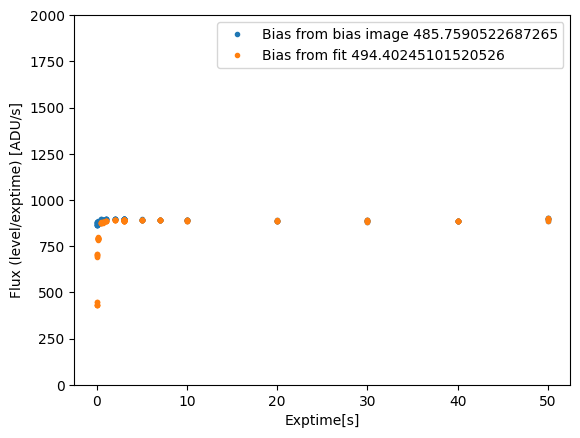

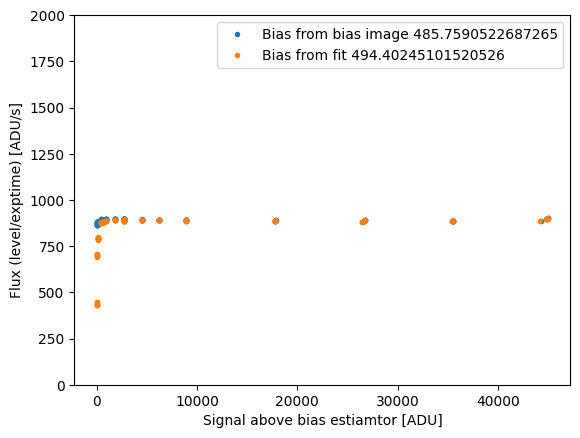

In [145]:
plt.figure()
biaslevel = np.median (levels [exptimes == 0]) 

print (f"Biaslevel: {biaslevel}")
plt.plot (exptimes, (levels-biaslevel) / exptimes,'.', label=f"Bias from bias image {biaslevel}")
plt.plot (exptimes, (levels-fittedbiaslevel) / exptimes,'.',label=f"Bias from fit {fittedbiaslevel}")
plt.legend()
plt.xlabel("Exptime[s]")
plt.ylabel ("Flux (level/exptime) [ADU/s]")
plt.ylim(0,2000)
plt.savefig ("flux_time.png")

plt.figure()
plt.plot (levels-biaslevel, (levels-biaslevel) / exptimes,'.', label=f"Bias from bias image {biaslevel}")
plt.plot (levels-fittedbiaslevel, (levels-fittedbiaslevel) / exptimes,'.',label=f"Bias from fit {fittedbiaslevel}")
plt.legend()
plt.xlabel("Signal above bias estiamtor [ADU]")
plt.ylabel ("Flux (level/exptime) [ADU/s]")
plt.ylim(0,2000)
plt.savefig ("flux_time.png")
